<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210923_AutedFE%E6%A4%9C%E8%A8%8E_DictL%E5%9F%BA%E7%A4%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data', 'notebook', 'C0002_21_09_2021.csv', 'C0002_23_09_2021.csv', 'ref']

In [3]:
os.listdir(os.path.join(DIR, 'data', 'Train_Unit_20210903'))

['Train_Unit_3', 'Train_Unit_2', 'Train_Unit_1', 'dataset_train_all.csv']

In [4]:
#データの読み込み
df_0 = pd.read_csv(
    os.path.join(DIR, 'data', 'Train_Unit_20210903', 'dataset_train_all.csv'),
    encoding='utf-8')

In [5]:
#不必要なIndex列と空白列を削除。
df_0 = df_0.drop(df_0.columns[[0, 7]], axis=1)

In [47]:
#データ処理用にDFをコピー
df = df_0.copy()

In [48]:
df.head()

,Time (s),Voltage Measured (V),Voltage Charge (V),Current Measured (Amps),Current Charge (Amps),Temperature (degree C),unit,charge_mode,Cycle_num,Voltage Load (V),Current Load (Amps)
0,0.000,3.6927,0.003,-0.004495,0.000,25.663,Train_Unit_3,Charge,90,NaN,NaN
1,2.453,3.1721,1.462,-3.573100,-3.563,25.660,Train_Unit_3,Charge,90,NaN,NaN
2,8.921,3.8846,4.618,1.505800,1.498,25.743,Train_Unit_3,Charge,90,NaN,NaN
3,15.156,3.9054,4.650,1.506600,1.500,25.835,Train_Unit_3,Charge,90,NaN,NaN
4,21.750,3.9165,4.661,1.509000,1.500,25.884,Train_Unit_3,Charge,90,NaN,NaN


In [49]:
#カラム名変更前後の辞書
col_list = {'Time (s)' : 'Time',
            'Voltage Measured (V)' : 'VM',
            'Voltage Charge (V)' : 'VC',
            'Current Measured (Amps)' : 'CM', 
            'Current Charge (Amps)' : 'CC',
            'Temperature (degree C)': 'Temp', 
            'unit' : 'unit_name', 
            'charge_mode' : 'mode', 
            'Cycle_num' : 'Cycle',
            'Voltage Load (V)' : 'VL',
            'Current Load (Amps)' : 'CL'
}

In [50]:
df = df.rename(columns=col_list)
df.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.6927,0.003,-0.004495,0.000,25.663,Train_Unit_3,Charge,90,NaN,NaN
1,2.453,3.1721,1.462,-3.573100,-3.563,25.660,Train_Unit_3,Charge,90,NaN,NaN
2,8.921,3.8846,4.618,1.505800,1.498,25.743,Train_Unit_3,Charge,90,NaN,NaN
3,15.156,3.9054,4.650,1.506600,1.500,25.835,Train_Unit_3,Charge,90,NaN,NaN
4,21.750,3.9165,4.661,1.509000,1.500,25.884,Train_Unit_3,Charge,90,NaN,NaN


In [51]:
#ユニットとサイクルでソート。
df = df.sort_values(['unit_name', 'Cycle']).reset_index(drop=True)

In [52]:
df.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,Train_Unit_1,Charge,1,NaN,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN


辞書学習用データの再確認

改めてわかったこと
データ数は、ユニット毎に違い、サイクル毎でも異なる。モード毎には違わない。  
⇒サイクル毎にインデックス数は異なる(データサイズが違う)が、Timeで見ると挙動は変わらない。  
⇒辞書学習のためには、フレーム数を揃えたいが、インデックスベースにするとミスリードする。  
⇒Timeをベースにデータを整えていく必要がある。

In [53]:
#サイクル毎のデータ数の確認
unit = 'Train_Unit_1'
feature = 'VM'
mode = 'Charge'
cycles = df[df['unit_name'] == unit]['Cycle'].unique()
cutoff_time = 3250

#for cycle in cycles:
#  tmp = df[ (df['unit_name'] == unit) & (df['Cycle'] == cycle) & (df['mode'] == mode)& (df['Time'] < cutoff_time)][feature]
#  print(f'{cycle}Cycleのデータ数：', tmp.shape[0])

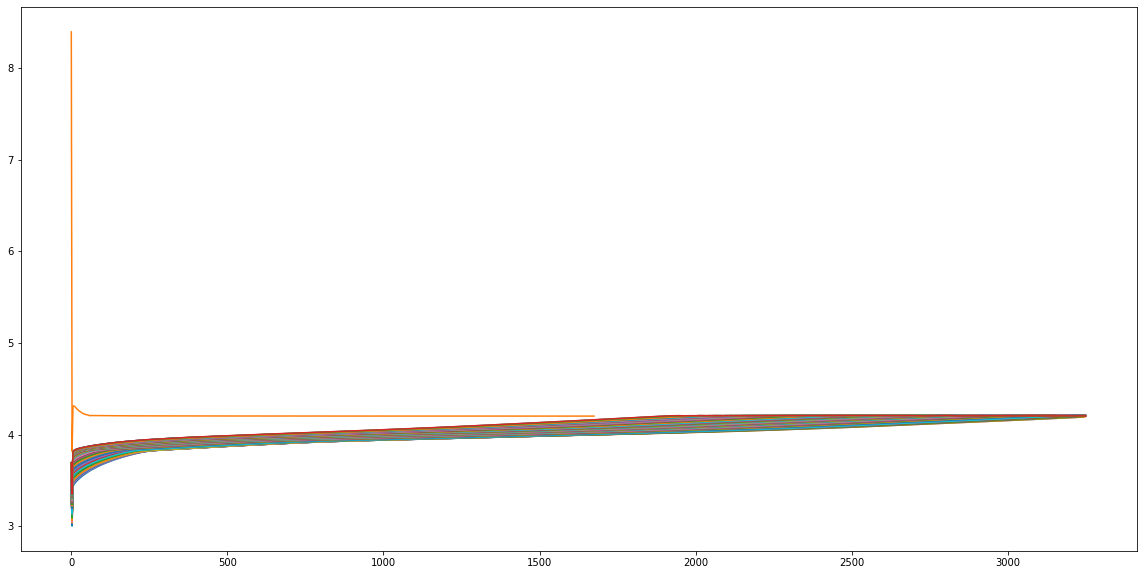

In [54]:
#プロット
unit = 'Train_Unit_1'
feature = 'VM'
mode = 'Charge'
cycles = df[df['unit_name'] == unit]['Cycle'].unique()
cutoff_time = 3250

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

for cycle in cycles:
  df_plot = df[df['Time'] < cutoff_time]
  plot_x = df_plot[ (df_plot['unit_name'] == unit) & (df_plot['Cycle'] == cycle) & (df_plot['mode'] == mode)]['Time']
  plot_y = df_plot[ (df_plot['unit_name'] == unit) & (df_plot['Cycle'] == cycle) & (df_plot['mode'] == mode)][feature]
  ax.plot(plot_x, plot_y, label= f'{unit}__{feature}__{cycle}Cycle')
  #ax.set_xticks(np.arange(0, cutoff_time, 250))
  #ax.set_ylim(3, 5)

#plt.legend()
plt.show()

外れ値と思われる波形を発見  
⇒除去する。

In [55]:
unit = 'Train_Unit_1'
feature = 'VM'
mode = 'Charge'

outlier_idx = df[df['unit_name'] == unit]['VM'].argmax()
outlier_idx

34406

In [56]:
df.iloc[outlier_idx,]#32サイクル目が異常

Time                    0
VM                 8.3931
VC                  0.003
CM            -0.00066675
CC                      0
Temp               23.899
unit_name    Train_Unit_1
mode               Charge
Cycle                  32
VL                    NaN
CL                    NaN
Name: 34406, dtype: object

In [58]:
#32サイクル目を除去。(=Cycle=32でないもののみ、抜き出し。)
df = df[df['Cycle'] !=32]

In [59]:
df.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,Train_Unit_1,Charge,1,NaN,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN


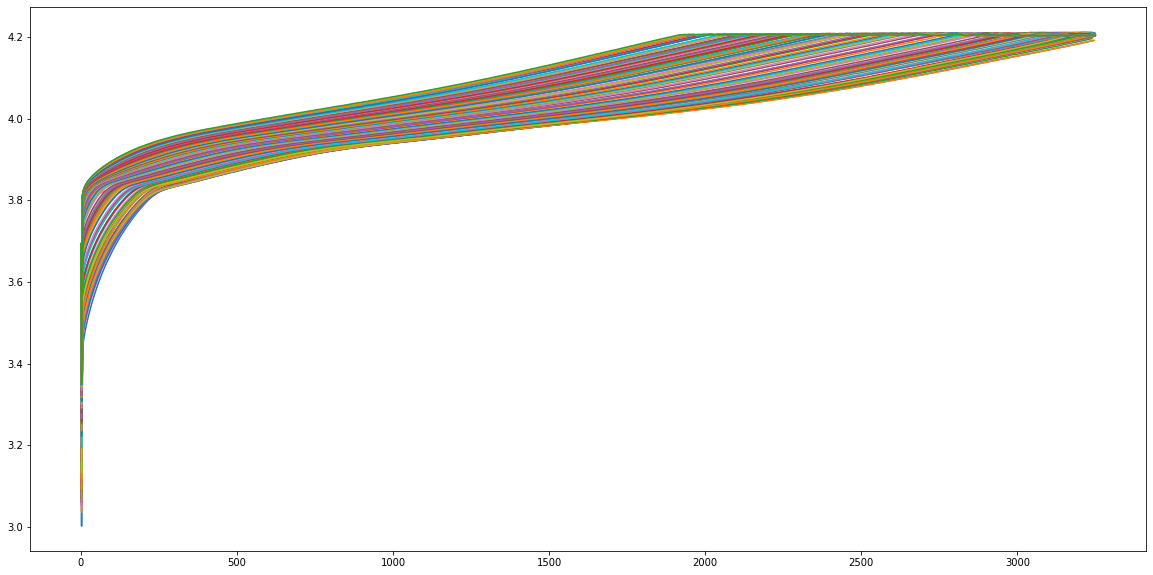

In [60]:
#プロット
unit = 'Train_Unit_1'
feature = 'VM'
mode = 'Charge'
cycles = df[df['unit_name'] == unit]['Cycle'].unique()
cutoff_time = 3250

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

for cycle in cycles:
  df_plot = df[df['Time'] < cutoff_time]
  plot_x = df_plot[ (df_plot['unit_name'] == unit) & (df_plot['Cycle'] == cycle) & (df_plot['mode'] == mode)]['Time']
  plot_y = df_plot[ (df_plot['unit_name'] == unit) & (df_plot['Cycle'] == cycle) & (df_plot['mode'] == mode)][feature]
  ax.plot(plot_x, plot_y, label= f'{unit}__{feature}__{cycle}Cycle')
  #ax.set_xticks(np.arange(0, cutoff_time, 250))
  #ax.set_ylim(3, 5)

#plt.legend()
plt.show()

辞書学習を用いるために、各サイクル毎で特徴量を抜き出すためのデータセットを作成する。


各サイクルをインスタンスとして、XX時間毎の特徴量を並べたピボットテーブルを作る。これが辞書学習に用いるデータとなる。

In [61]:
import warnings
warnings.simplefilter('ignore')

In [62]:
unit = 'Train_Unit_1'
feature = 'VM'
mode = 'Charge'
cutoff_time = 3250

df_dict_base = df[ (df['unit_name'] == unit) & (df['mode'] == mode) & (df['Time'] < cutoff_time)]

In [63]:
df_dict_base.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,Train_Unit_1,Charge,1,NaN,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN


In [64]:
df_tmp = df_dict_base[['Time','VM', 'Cycle']]

In [65]:
df_tmp.head()

,Time,VM,Cycle
0,0.000,3.3251,1
1,2.516,3.0020,1
2,5.500,3.4346,1
3,8.391,3.4549,1
4,11.266,3.4688,1


In [66]:
df_tmp['Time'] = round(df_tmp['Time'])

In [67]:
df_tmp[df_tmp['Cycle'] == 124]

,Time,VM,Cycle
406330,0.0,3.6939,124
406331,3.0,3.3507,124
406332,5.0,3.8111,124
406333,8.0,3.8228,124
406334,10.0,3.8294,124
...,...,...,...
407552,3237.0,4.2052,124
407553,3240.0,4.2045,124
407554,3243.0,4.2046,124
407555,3246.0,4.2041,124


35秒間に1回ランダムに抜き出す(or 統計量でもOK)データセットを作成  
⇒1サイクルあたり、3500/35 = 100コのかたまりができるイメージ。

In [68]:
df_tmp_1 = df_tmp[df_tmp['Cycle'] == 1]

In [69]:
df_tmp_1.head()
#df_tmp_1['Time'].dtype

,Time,VM,Cycle
0,0.0,3.3251,1
1,3.0,3.0020,1
2,6.0,3.4346,1
3,8.0,3.4549,1
4,11.0,3.4688,1


In [70]:
#グループIDを付与する。
group_list = []
for i in np.arange(1, 100):
    lower = 35*i-35
    upper = 35*i
    tmp_df = df_tmp_1[ (lower < df_tmp_1['Time']) & (upper > df_tmp_1['Time'])]
    tmp_df['group_id'] = f'{lower} -- {upper}'
    group_list.append(tmp_df)

In [71]:
df_add_group = pd.concat(group_list)
df_add_group

,Time,VM,Cycle,group_id
1,3.0,3.0020,1,0 -- 35
2,6.0,3.4346,1,0 -- 35
3,8.0,3.4549,1,0 -- 35
4,11.0,3.4688,1,0 -- 35
5,14.0,3.4810,1,0 -- 35
...,...,...,...,...
501,3196.0,4.1931,1,3185 -- 3220
502,3207.0,4.1949,1,3185 -- 3220
503,3219.0,4.1963,1,3185 -- 3220
504,3230.0,4.1984,1,3220 -- 3255


In [72]:
grouped_mean = df_add_group.groupby('group_id').agg('mean')
grouped_mean = grouped_mean.sort_values('Time')

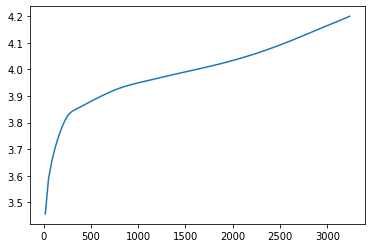

In [73]:
fig, ax = plt.subplots()

ax.plot(grouped_mean.Time, grouped_mean.VM)

plt.show()

In [74]:
#関数化：グループIDを付与する。
def add_group(df, interval):
  group_list = []
  for i in np.arange(1, 3500/interval):
      lower = interval*i-interval
      upper = interval*i
      tmp_df = df[ (lower < df['Time']) & (upper > df['Time'])]
      tmp_df['group_id'] = f'{lower} -- {upper}'
      group_list.append(tmp_df)
  df_add_group = pd.concat(group_list)
  return df_add_group

In [75]:
#インターバルは50。
df_grouped = add_group(df, interval=50)

In [76]:
df_grouped = df_grouped.reset_index(drop=True)

In [78]:
df_grouped.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL,group_id
0,2.516,3.0020,1.414,-3.3620,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
1,5.500,3.4346,4.142,1.5087,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
2,8.391,3.4549,4.180,1.5100,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
3,11.266,3.4688,4.196,1.5087,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
4,14.141,3.4810,4.207,1.5116,1.500,29.323,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0


In [79]:
grouped = df_grouped.groupby(['Cycle', 'group_id'])

In [80]:
grouped_mean = grouped.mean().sort_values(['Cycle','Time'])

In [81]:
#ピボットテーブルを作成
pt = pd.pivot_table(grouped_mean, index='Cycle', columns='group_id', values='VM')
pt

group_id,0.0 -- 50.0,100.0 -- 150.0,1000.0 -- 1050.0,1050.0 -- 1100.0,1100.0 -- 1150.0,1150.0 -- 1200.0,1200.0 -- 1250.0,1250.0 -- 1300.0,1300.0 -- 1350.0,1350.0 -- 1400.0,1400.0 -- 1450.0,1450.0 -- 1500.0,150.0 -- 200.0,1500.0 -- 1550.0,1550.0 -- 1600.0,1600.0 -- 1650.0,1650.0 -- 1700.0,1700.0 -- 1750.0,1750.0 -- 1800.0,1800.0 -- 1850.0,1850.0 -- 1900.0,1900.0 -- 1950.0,1950.0 -- 2000.0,200.0 -- 250.0,2000.0 -- 2050.0,2050.0 -- 2100.0,2100.0 -- 2150.0,2150.0 -- 2200.0,2200.0 -- 2250.0,2250.0 -- 2300.0,2300.0 -- 2350.0,2350.0 -- 2400.0,2400.0 -- 2450.0,2450.0 -- 2500.0,250.0 -- 300.0,2500.0 -- 2550.0,2550.0 -- 2600.0,2600.0 -- 2650.0,2650.0 -- 2700.0,2700.0 -- 2750.0,2750.0 -- 2800.0,2800.0 -- 2850.0,2850.0 -- 2900.0,2900.0 -- 2950.0,2950.0 -- 3000.0,300.0 -- 350.0,3000.0 -- 3050.0,3050.0 -- 3100.0,3100.0 -- 3150.0,3150.0 -- 3200.0,3200.0 -- 3250.0,3250.0 -- 3300.0,3300.0 -- 3350.0,3350.0 -- 3400.0,3400.0 -- 3450.0,350.0 -- 400.0,400.0 -- 450.0,450.0 -- 500.0,50.0 -- 100.0,500.0 -- 550.0,550.0 -- 600.0,600.0 -- 650.0,650.0 -- 700.0,700.0 -- 750.0,750.0 -- 800.0,800.0 -- 850.0,850.0 -- 900.0,900.0 -- 950.0,950.0 -- 1000.0
Cycle,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.658397,3.762069,3.856364,3.849993,3.863136,3.873609,3.863800,3.853721,3.876270,3.867183,3.868777,3.868507,3.784315,3.869253,3.979012,3.981745,3.985219,3.986012,3.989096,3.994312,3.997476,4.001065,4.000261,3.803339,4.009741,4.012802,4.014382,4.016145,4.025162,4.024424,4.031143,4.035700,4.034683,4.041996,3.814612,4.053502,4.046424,4.029547,4.056354,4.046000,4.039340,4.033872,4.031462,4.014846,4.012321,3.819942,4.001918,4.059548,4.147697,4.120141,4.113115,4.134655,4.086813,4.198808,4.198580,3.822552,3.818140,3.829578,3.722052,3.836450,3.842465,3.840634,3.846148,3.850787,3.845183,3.834508,3.855388,3.848402,3.856142
2,3.686465,3.772765,3.866779,3.860007,3.853968,3.870229,3.864839,3.866718,3.874268,3.857193,3.859925,3.857362,3.797933,3.983438,3.969483,3.980642,3.993968,3.986718,3.991525,4.002614,3.998144,3.990900,4.013873,3.814039,4.010122,4.000261,4.025869,4.017931,4.024073,4.024033,4.031743,4.049967,4.021583,4.043513,3.823997,4.053002,4.042289,4.029731,4.057461,4.040785,4.030661,4.031039,4.023046,4.030620,3.967070,3.829252,4.078539,4.127162,4.146513,4.114841,4.139976,4.131250,4.116522,4.198989,4.199360,3.829649,3.838905,3.841868,3.744651,3.843475,3.835982,3.855075,3.856736,3.852352,3.863537,3.860017,3.858823,3.863022,3.868814
3,3.696014,3.781859,3.861064,3.864218,3.864930,3.871593,3.863112,3.863567,3.871413,3.863176,3.851211,3.930484,3.802447,3.983742,3.978458,3.978545,3.993078,3.987498,3.976868,4.003387,3.997822,4.001628,3.999848,3.817300,4.009626,4.008590,4.023522,4.006992,4.023681,4.036763,4.033083,4.046354,4.022692,4.042842,3.826573,4.054137,4.043134,4.040859,4.053073,4.033498,4.050674,4.002096,4.019139,4.017943,3.979268,3.831277,4.111447,4.125589,4.144727,4.114395,4.137632,4.099785,4.154303,4.199006,4.199251,3.832833,3.838149,3.844144,3.752952,3.845283,3.850978,3.852090,3.857540,3.856486,3.850773,3.857792,3.864217,3.862456,3.869059
4,3.703310,3.786855,3.866860,3.868239,3.857759,3.871087,3.849170,3.861196,3.865137,3.855481,3.857009,3.974538,3.807419,3.981583,3.977431,3.978552,3.992335,3.989430,3.976624,4.005657,3.996640,3.998667,4.017558,3.822056,4.006556,4.013014,4.027983,4.016326,4.012716,4.042443,4.030185,4.047785,4.020326,4.038917,3.827982,4.055496,4.037027,4.043798,4.028516,4.029107,4.042716,4.016170,3.995460,4.001005,3.993212,3.833170,4.146951,4.122705,4.144616,4.113497,4.135150,4.097600,4.152524,4.199260,4.199279,3.839879,3.841382,3.844763,3.755455,3.847159,3.854223,3.856360,3.851419,3.862134,3.863888,3.863295,3.858498,3.864791,3.869040
5,3.741900,3.804505,3.865162,3.860229,3.866758,3.869592,3.866885,3.864509,3.861059,3.858577,3.856411,3.919370,3.819933,3.981663,3.965249,3.978425,3.992452,3.984527,3.987677,4.000838,3.982165,3.995147,4.012054,3.831077,4.005460,4.010260,4.011740,4.015919,4.019717,4.036240,4.033117,4.019153,4.05

In [82]:
pt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 1 to 124
Data columns (total 69 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   0.0 -- 50.0       123 non-null    float64
 1   100.0 -- 150.0    123 non-null    float64
 2   1000.0 -- 1050.0  123 non-null    float64
 3   1050.0 -- 1100.0  123 non-null    float64
 4   1100.0 -- 1150.0  123 non-null    float64
 5   1150.0 -- 1200.0  123 non-null    float64
 6   1200.0 -- 1250.0  123 non-null    float64
 7   1250.0 -- 1300.0  123 non-null    float64
 8   1300.0 -- 1350.0  123 non-null    float64
 9   1350.0 -- 1400.0  123 non-null    float64
 10  1400.0 -- 1450.0  123 non-null    float64
 11  1450.0 -- 1500.0  123 non-null    float64
 12  150.0 -- 200.0    123 non-null    float64
 13  1500.0 -- 1550.0  123 non-null    float64
 14  1550.0 -- 1600.0  123 non-null    float64
 15  1600.0 -- 1650.0  123 non-null    float64
 16  1650.0 -- 1700.0  123 non-null    float64
 1

In [83]:
X = np.asarray(pt.values)
X_train = X

In [85]:
from sklearn.decomposition import DictionaryLearning

In [86]:
n_components = 4
dict_learner = DictionaryLearning(
    n_components=n_components,
    fit_algorithm='cd',
    transform_algorithm = 'lasso_lars',
    random_state = 42,
    positive_code = True,
    positive_dict = True,
    alpha = 1
)

In [87]:
X_train_transformed = dict_learner.fit_transform(X_train)

辞書(特徴量)のプロット

In [95]:
time_range = np.arange(dict_learner.components_.shape[1])
time_range

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68])

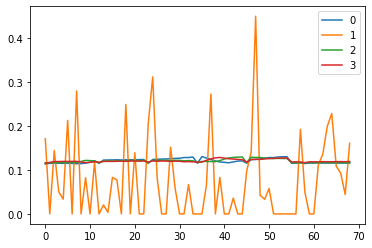

In [97]:
for i in range(n_components):
  plt.plot(time_range, dict_learner.components_[i], label=i)
plt.legend()
plt.show()

In [99]:
len(dict_learner.components_[1])

69

サイクルと秒数を逆にしてみる。  
⇒サイクル毎の特徴量が欲しいため。

In [100]:
#ピボットテーブルを作成
pt_2 = pd.pivot_table(grouped_mean, index='group_id', columns='Cycle', values='VM')
pt_2

Cycle,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124
group_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0 -- 50.0,3.658397,3.686465,3.696014,3.703310,3.741900,3.756082,3.703457,3.716892,3.718525,3.753341,3.708044,3.786640,3.722609,3.725337,3.745685,3.724653,3.726763,3.728196,3.729011,3.823561,3.763950,3.727062,3.736790,3.746721,3.745862,3.773352,3.755873,3.751640,3.752658,3.759398,3.798940,3.748943,3.764651,3.777076,3.799113,3.782978,3.784933,3.787496,3.790450,3.774347,...,3.825261,3.824286,3.825111,3.827800,3.826011,3.830561,3.828747,3.820539,3.822364,3.825178,3.825547,3.836300,3.836060,3.853350,3.853480,3.854633,3.854850,3.855213,3.855008,3.862162,3.852546,3.854279,3.854129,3.855758,3.856954,3.855650,3.855946,3.857779,3.858317,3.857521,3.857504,3.858440,3.858787,3.859546,3.858829,3.857904,3.861146,3.855696,3.858362,3.859588
100.0 -- 150.0,3.762069,3.772765,3.781859,3.786855,3.804505,3.803734,3.785355,3.792665,3.792515,3.807725,3.787492,3.822612,3.797525,3.797453,3.806766,3.794737,3.798205,3.794879,3.801505,3.853446,3.818457,3.803514,3.807565,3.811613,3.815823,3.824330,3.817575,3.812910,3.815121,3.823408,3.829293,3.800395,3.811897,3.818479,3.828738,3.821811,3.821198,3.828173,3.824312,3.815212,...,3.843097,3.836046,3.837227,3.840227,3.837903,3.844981,3.845022,3.833478,3.834789,3.833233,3.835831,3.835275,3.838243,3.884868,3.885044,3.887108,3.887636,3.888336,3.888952,3.902152,3.884729,3.886832,3.887724,3.889892,3.891940,3.890252,3.890608,3.893688,3.894664,3.893808,3.894036,3.895020,3.896104,3.897472,3.896476,3.896804,3.900156,3.890752,3.895320,3.897876
1000.0 -- 1050.0,3.856364,3.866779,3.861064,3.866860,3.865162,3.867393,3.851207,3.860758,3.857042,3.859038,3.852640,3.857067,3.851671,3.853943,3.868853,3.847680,3.851419,3.858047,3.844214,3.854746,3.851178,3.841844,3.857328,3.835278,3.836557,3.873257,3.836422,3.838217,3.853176,3.833584,3.853343,3.856511,3.857172,3.871364,3.864545,3.851430,3.864739,3.868079,3.867607,3.828446,...,3.850771,3.855627,3.856997,3.882889,3.851621,3.864762,3.860203,3.853846,3.847850,3.880571,3.848626,3.860081,3.855914,3.937300,3.923854,3.921332,3.940856,3.941480,3.943104,3.948252,3.933954,3.921820,3.927158,3.929350,3.946084,3.944936,3.941533,3.933331,3.929768,3.933708,3.949468,3.950684,3.952260,3.949625,3.953184,3.954884,3.950872,3.942571,3.951412,3.938115
1050.0 -- 1100.0,3.849993,3.860007,3.864218,3.868239,3.860229,3.865059,3.857852,3.854198,3.857351,3.862549,3.868984,3.853798,3.871892,3.850486,3.869353,3.844298,3.865480,3.841508,3.861249,3.871762,3.848048,3.858960,3.842898,3.839147,3.866209,3.839364,3.851639,3.859126,3.835922,3.859867,3.844691,3.861432,3.862298,3.844836,3.867876,3.864960,3.853364,3.853164,3.863160,3.850774,...,3.857795,3.847950,3.875995,3.847676,3.858662,3.859797,3.879205,3.880756,3.875646,3.857484,3.847700,3.852576,3.848371,3.925315,3.940240,3.942044,3.938983,3.929158,3.930785,3.935931,3.929567,3.942836,3.944440,3.946752,3.933508,3.932381,3.932742,3.951324,3.948233,3.951900,3.931688,3.953488,3.939123,3.956644,3.940077,3.953346,3.953408,3.933708,3.933204,3.957128
1100.0 -- 1150.0,3.863136,3.853968,3.864930,3.857759,3.866758,3.862462,3.860938,3.857409,3.864150,3.859048,3.850159,3.854243,3.852155,3.853767,3.849733,3.872504,3.841431,3.848551,3.842060,3.861389,3.863265,3.837509,3.859883,3.854380,3.837611,3.857327,3.842827,3.853598,3.859800,3.834380,3.853447,3.847483,3.869427,3.871855,3.851682,3.868915,3.865614,3.868529,3.856350,3.856030,...,3.857711,3.889095,3.856924,3.859427,3.858492,3.856819,3.860146,3.853146,3.854238,3.849611,3.859516,3.887828,3.888183,3.942140,3.943016,3.944896,3.945732,3.946708,3.948556,3.948983,3.938563,3.945760,3.947596,3.949976,3.951792,3.950680,3.951348,3.950129,3.955752,3.955308,3.955432,3.956932,3.958624,3.960260,

In [101]:
X_2 = np.asarray(pt_2.values)
X_train_2 = X_2

In [111]:
n_components = 10
dict_learner_2 = DictionaryLearning(
    n_components=n_components,
    fit_algorithm='cd',
    transform_algorithm = 'lasso_lars',
    random_state = 42,
    positive_code = True,
    positive_dict = True,
    alpha = 1
)

In [112]:
X_train_transformed_2 = dict_learner_2.fit_transform(X_train_2)

In [113]:
time_range = np.arange(dict_learner_2.components_.shape[1])
time_range

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122])

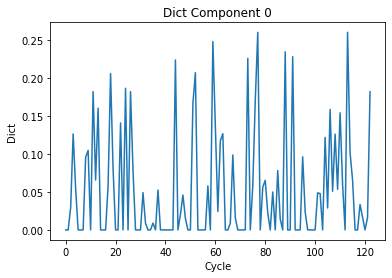

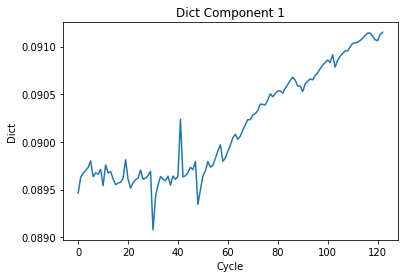

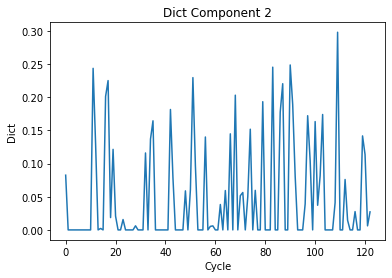

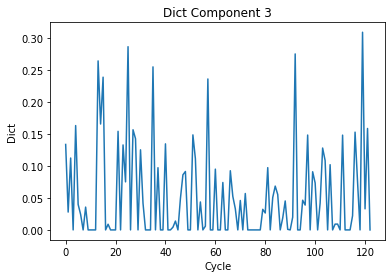

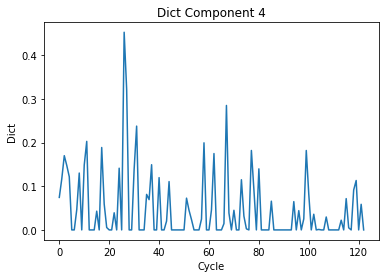

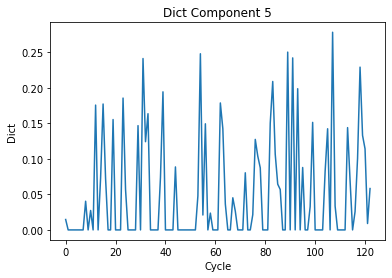

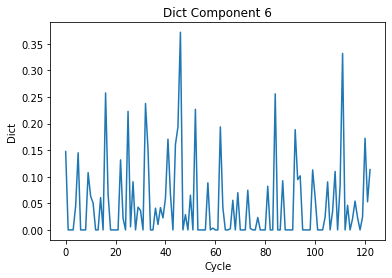

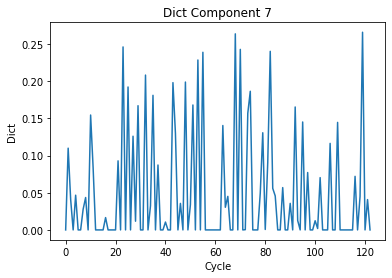

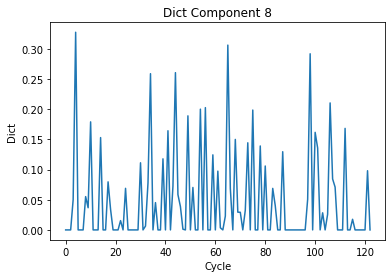

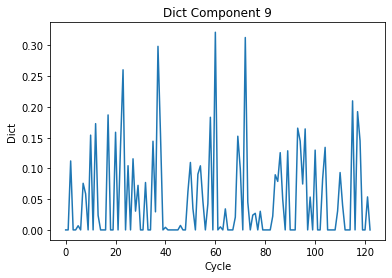

In [115]:
for i in range(n_components):
  fig, ax = plt.subplots()
  ax.plot(time_range, dict_learner_2.components_[i])
  ax.set_title(f'Dict Component {i}')
  ax.set_xlabel('Cycle')
  ax.set_ylabel('Dict')
  #plt.legend()
  plt.show()

Dict Component1について、Cycle毎に増えている特徴量が獲得されている。  
⇒おそらく、これはCycleを経るごとに進む劣化の特徴を掴んできている。  
⇒VMについては、Dict Component1を特徴量に使う。  